<a href="https://colab.research.google.com/github/pdthuc/Project_SeamCarving/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  print("Image size (width x height): {} x {}".format(w, h))
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

# Kiểm tra có mount được đến thư mục chứa data hay không?
os.chdir("/content/drive/My Drive/LTSS/Me/Final")
!ls

Mounted at /content/drive
'09 01-Report.ipynb'   out_host.pnm   SeamCarving
 15-In.pnm	       Report.ipynb   SeamCarving.cu


Image size (width x height): 640 x 434


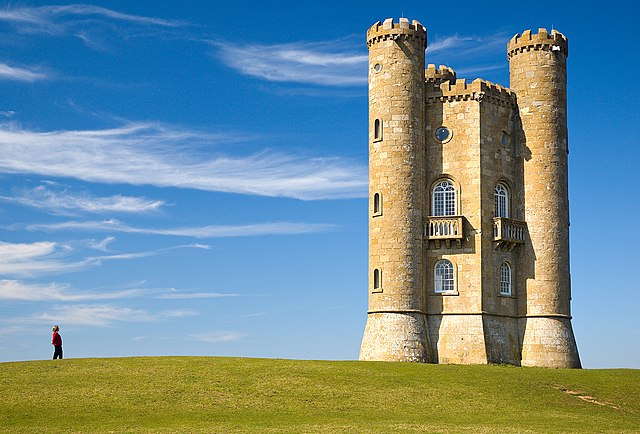

In [3]:
show_pnm('15-In.pnm')

# ĐỒ ÁN CUỐI KỲ MÔN "LẬP TRÌNH SONG SONG"
### GVHD: TRẦN TRUNG KIÊN
### THỰC HIỆN: Nhóm 11
### DANH SÁCH THÀNH VIÊN
 1. 18120579 - ĐẶNG MINH THỌ
 2. 10120584 - PHẠM ĐÌNH THỤC

Link kế hoạch làm việc nhóm: https://docs.google.com/spreadsheets/d/1ut2bqyMlK3yd02dfPk-1-aYlFGSHFWV332MrNUD2DmQ/edit#gid=0

# 1. MÔ TẢ ỨNG DỤNG

- **Ứng dụng nhóm chọn**: Seam Carving
  - *Seam Carving* là một thuật toán để thay đổi kích thước hình ảnh.
  -  Mục đích của thuật toán là thay đổi kích thước hình ảnh mà các đối tượng chính trong hình ảnh không bị biến dạng
- **Input**: một tấm ảnh (đồ án này: ảnh RGB)
- **Output**: tấm ảnh được thay đổi kích thước mà không làm biến dạng các đối tượng quan trọng (đồ án này: tấm ảnh được thu hẹp chiều rộng lại)
- **Ý nghĩa thực tế của ứng dụng**: 
  - Một use case là ta có thể muốn có các phiên bản với các kích thước khác nhau của cùng một tấm ảnh để hiển thị trên các thiết bị khác nhau (máy tính, điện thoại, ...)
  - Ngoài ra, ứng dụng có thể được áp dụng vào các app chỉnh sửa ảnh.
- **Ứng dụng này có cần tăng tốc không?**
  - Cần, ứng dụng này chạy chậm khi cài đặt tuần tự

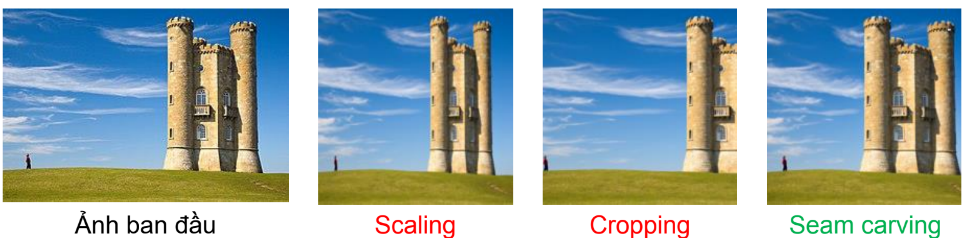

*Nguồn ảnh: Trang 16 Slide 15-DoAnCK.pdf*

# 2. CÀI ĐẶT TUẦN TỰ

## 2.1 THIẾT KẾ
*(chú thích: Energy - độ quan trọng)*
- Yêu cầu: Thu hẹp chiều rộng ảnh xuống còn n 
- **Input**: ảnh RGB 
- Đọc ảnh đầu vào 
- Dùng edge detection để tính độ quan trọng của mỗi pixel
  - Chuyển ảnh đầu vào sang ảnh grayscale
  - Thực hiện *convolution* giữa ảnh grayscale với bộ lọc x-Sobel *(1)*
$$\begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix}$$
  - Thực hiện *convolution* giữa ảnh grayscale với bộ lọc y-Sobel *(2)*
$$\begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$
  - Tính độ quan trọng của một pixel
```
 Energy của một pixel = |kết quả (1)| + |kết quả (2)|
```
- Tìm seam ít quan trọng nhất từ độ quan trọng của các pixel
  - Tính toán đường nối bao gồm việc tìm đường đi có độ quan trọng nhỏ nhất từ đầu này đến đầu kia của hình ảnh (vì đồ án chỉ thu hẹp chiều rộng nên sẽ đường đi sẽ từ cạnh trên đến cạnh dưới của ảnh)
  - Seam có độ quan trọng được tính bằng 
```
 Energy của seam = Energy của pixel hiện tại + Min (Energy của các pixel liền kề bên dưới được kết nối)
```
  - Trong đó: các pixel liền kề bên dưới được kết nối lần lượt là các pixel ở vị trí left, down và right. 
- Tiếp theo, ta xóa Seam vừa tìm được
- Ghi ảnh đầu ra
- **Output**: Ảnh đã xóa 1 seam (có nghĩa là giảm 1 pixel theo chiều ngang)
- Tiến hành lặp lại quá trình cho đến khi đạt được chiều rộng phù hợp (= n)



## 2.2 ĐÁNH GIÁ

In [4]:
!nvcc SeamCarving.cu -o SeamCarving

In [5]:
!./SeamCarving 500 15-In.pnm out.pnm 

Error: SeamCarving.cu:335, code: 100, reason: no CUDA-capable device is detected


Image size (width x height): 500 x 434


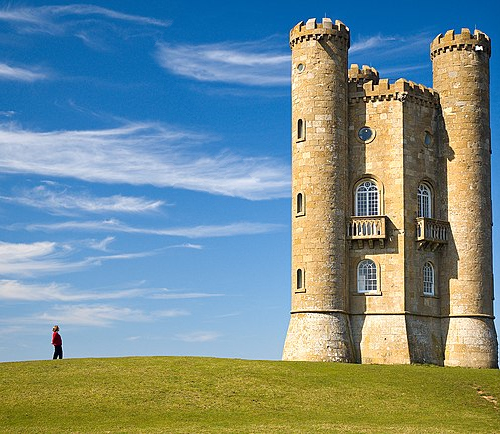

In [6]:
show_pnm('out_host.pnm')


# 3. CÀI ĐẶT SONG SONG

# 4. CÀI ĐẶT SONG SONG + TỐI ƯU HÓA

# 5. NHÌN LẠI QUÁ TRÌNH LÀM ĐỒ ÁN

# 6. TÀI LIỆU THAM KHẢO